In [2]:
import sys

from datetime import datetime, timedelta
from importlib import reload

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from hyperopt import hp, fmin, tpe, pyll


sys.path.append('../')
import src.model as model

plt.style.use("fivethirtyeight")

In [3]:
reload(model)

<module 'src.model' from '../src/model.py'>

We load the cleaned data from the `data_clean` folder. Please ensure the script to clean data in `src/clean_data.py` is executed first by running `python src/clean_data.py` from the terminal

In [4]:
cases_df = pd.read_parquet('../data_clean/cases.pq')
deaths_df = pd.read_parquet('../data_clean/deaths.pq')
mask_compliance_df = pd.read_parquet('../data_clean/mask_compliance.pq')
mask_mandates_df = pd.read_parquet('../data_clean/mask_mandates.pq')

For Oakland County in Michigan the fips code is 26125

In [5]:
fip = "26125"

We filter the county cases dataframe and county mandates dataframes to get only the rows corresponding to the county that we are interested in.

In [6]:
county_cases_df = cases_df[cases_df["FIPS"] == fip]
county_cases_df["Date"] = county_cases_df["variable"].astype("datetime64")
# county_cases_df = county_cases_df.set_index("Date")

county_mandates = mask_mandates_df[mask_mandates_df["FIPS"] == fip]
county_mandates["date"] = county_mandates["date"].astype("datetime64")
# county_mandates = county_mandates.set_index("date")

/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We get the daily cases by getting the difference from the `values` column since that `values` stores the aggregate case count

In [7]:
county_cases_df["daily"] = county_cases_df["value"].diff().fillna(county_cases_df["value"])

/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


We filter the compliance dataframe for the selected county

In [8]:
county_compliance = mask_compliance_df[mask_compliance_df["FIPS"] == fip]
county_compliance

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,FIPS
1293,26125,0.028,0.027,0.049,0.169,0.727,26125


Next, we create a new dataframe by merging cases and mandates dataframes together on columns `FIPS` and `Date`

In [9]:
new_df = pd.merge(
    county_cases_df, 
    county_mandates[["FIPS", "Face_Masks_Required_in_Public", "date"]],
    how='left',
    left_on=['FIPS', 'Date'],
    right_on=['FIPS', 'date']
)

We modify this newly created dataframe to fill na values in the masking column, set date as index and filter out the dates beyond October 1st, 2021.
We also calculate a rolling 7 day average of the daily cases to smoothen the case counts since they can be very noisy at day level.
Based on [this study](https://www.nature.com/articles/s41467-020-18272-4), we estimate the total number of infections at a given time from case counts by multiplying it by a factor of 9 (underestimation factor obtained from the linked study) and taking a rolling sum over 10 days (average infectious period)

In [10]:
new_df = new_df.fillna({"Face_Masks_Required_in_Public": "No"})
new_df = new_df.set_index("Date")
new_df["mask"] = new_df["Face_Masks_Required_in_Public"].apply(lambda x: 1 if x=="Yes" else 0)
new_df = new_df[new_df.index <= pd.Timestamp('2021-10-01')]
new_df['daily_7d_ma'] = new_df['daily'].rolling(7).mean()
new_df['infections'] = new_df['daily_7d_ma'].rolling(10).sum()*9

We plot the masking madate dates, daily case counts, 7 day moving average of daily case counts and the number of infectious people at a given time.

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

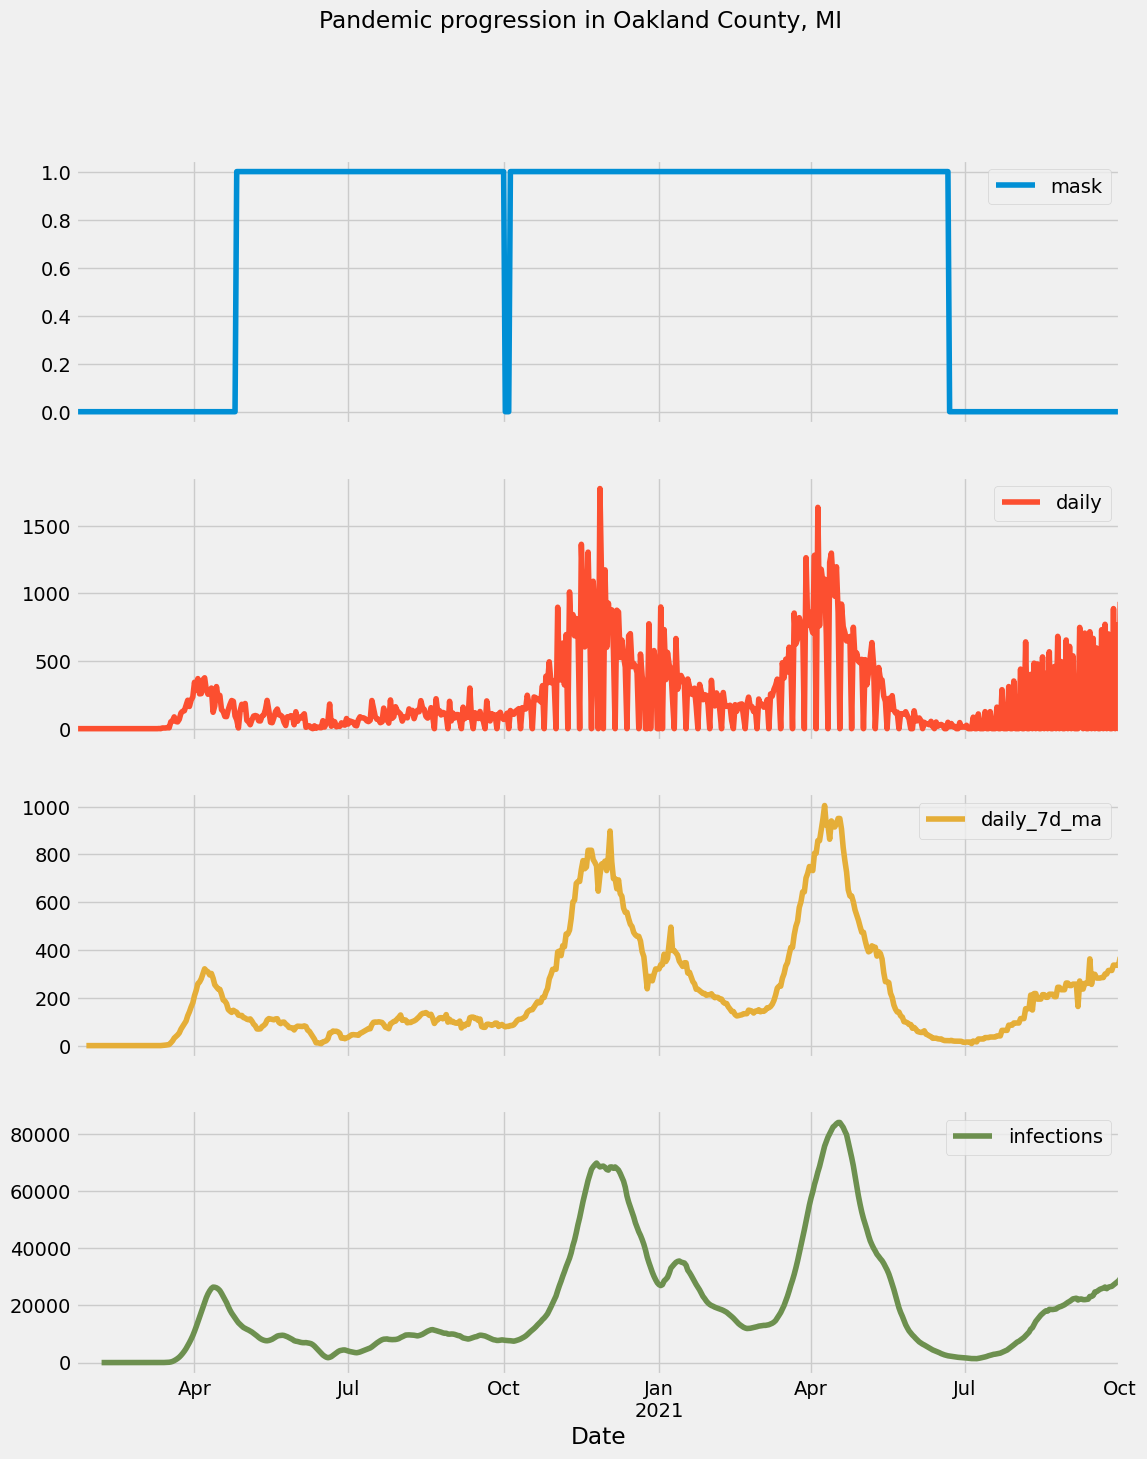

In [38]:
# plt.figure(figsize=(15, 6))
new_df[["mask", "daily", "daily_7d_ma", "infections"]].plot(subplots=True, figsize=(12, 15), title="Pandemic progression in Oakland County, MI")

We can see that two waves occur during the mask mandate period whereas the first and the last wave occur outside it. 

In our analysis, we estimate the impact of masking by fitting a [SIRS model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) to the data. We do the following steps:
- fit a SIRS model to wave 1 and wave 4 and estimate the beta parameter 
- fit a different SIRS model to wave 2 and wave 3 and estimate the beta parameter
- compare the two beta parameters to identify when the virus spread was faster since a higher beta value implies a faster spread of infections

We first get the start and mid dates of the infection wave for the four waves.  
Note we only fit model during the period when the wave rises because [SIRS models are not able to capture multiple waves](https://arxiv.org/abs/0912.1250)

In [13]:
wave1_start = datetime(year=2020, month=3, day=15)
wave1_mid = datetime(year=2020, month=4, day=7)

wave2_start = datetime(year=2020, month=10, day=7)
wave2_mid = datetime(year=2020, month=11, day=7)

wave3_start = datetime(year=2021, month=3, day=1)
wave3_mid = datetime(year=2021, month=4, day=1)

wave4_start = datetime(year=2021, month=7, day=6)
wave4_mid = datetime(year=2021, month=8, day=6)

Next, we filter the merged dataframes between the four wave durations that we extracted above

In [14]:
wave1 = new_df[np.logical_and(new_df.index >= wave1_start, new_df.index <= wave1_mid)]
wave2 = new_df[np.logical_and(new_df.index >= wave2_start, new_df.index <= wave2_mid)]
wave3 = new_df[np.logical_and(new_df.index >= wave3_start, new_df.index <= wave3_mid)]
wave4 = new_df[np.logical_and(new_df.index >= wave4_start, new_df.index <= wave4_mid)]

We define parameters related to the infection spread which will be used by the SIRS model.  
SIRS model has been implemented in `src/model.py`

In [16]:
time_infection_to_recovery = 10
gamma = 1/time_infection_to_recovery

infection_immunity_period = 60
delta = 1/infection_immunity_period

# beta_wo_mask = 0.3        # to be estimated by curve fitting
# beta_mask = 0.3           # to be estimated by curve fitting

population = 1274000

Other inputs that needs to be specified to the SIRS model include 
- i0 which denotes the count of infected population at the start of the simulation
- r0 which denotes the count of recovered population at the start of the simulation
- s0 which denotes the count of susceptible population at the start of the simulation

We assume the total population remains constant during the four wave periods.  
Thus, population = i0 + r0 + s0

We first estimate i0 using the `infections` column that we calculated earlier

In [17]:
wave1_i0 = wave1['infections'].head(1).item()
wave2_i0 = wave2['infections'].head(1).item()
wave3_i0 = wave3['infections'].head(1).item()
wave4_i0 = wave4['infections'].head(1).item()

Next, we estimate r0 by summing the total number of infections in the past 60 days. We do this by counting the daily cases and multiplying by the underestimation factor of 9.

In [18]:
wave1_r0 = new_df['daily'][np.logical_and(new_df.index >= wave1_start - timedelta(days=60), new_df.index < wave1_start)].sum()*9
wave2_r0 = new_df['daily'][np.logical_and(new_df.index >= wave2_start - timedelta(days=60), new_df.index < wave2_start)].sum()*9
wave3_r0 = new_df['daily'][np.logical_and(new_df.index >= wave3_start - timedelta(days=60), new_df.index < wave3_start)].sum()*9
wave4_r0 = new_df['daily'][np.logical_and(new_df.index >= wave4_start - timedelta(days=60), new_df.index < wave4_start)].sum()*9

Next, we define a function that calculates how good our fit to the model is for a given value of `beta_mask`, `beta_wo_mask`.
This function simulates the four waves for the given parameters and calculates the squared difference between the fitted infection values and observed infection values.

In [19]:
def calculate_loss(arg_dict):
    beta_mask = arg_dict['beta_mask']
    beta_wo_mask = arg_dict['beta_wo_mask']
    wave1_model = model.SIRSModel(
        N = population,
        beta = beta_wo_mask,
        gamma = gamma,
        delta = delta,
        s0 = population-wave1_i0-wave1_r0,
        i0 = wave1_i0,
        r0 = wave1_r0,
        first_infection = wave1_start,
        end_date = wave1_mid,
    )

    wave2_model = model.SIRSModel(
        N = population,
        beta = beta_mask,
        gamma = gamma,
        delta = delta,
        s0 = population-wave2_i0-wave2_r0,
        i0 = wave2_i0,
        r0 = wave2_r0,
        first_infection = wave2_start,
        end_date = wave2_mid,
    )

    wave3_model = model.SIRSModel(
        N = population,
        beta = beta_mask,
        gamma = gamma,
        delta = delta,
        s0 = population-wave3_i0-wave3_r0,
        i0 = wave3_i0,
        r0 = wave3_r0,
        first_infection = wave3_start,
        end_date = wave3_mid,
    )

    wave4_model = model.SIRSModel(
        N = population,
        beta = beta_wo_mask,
        gamma = gamma,
        delta = delta,
        s0 = population-wave4_i0-wave4_r0,
        i0 = wave4_i0,
        r0 = wave4_r0,
        first_infection = wave4_start,
        end_date = wave4_mid,
    )

    res1 = wave1_model.simulate()
    res2 = wave2_model.simulate()
    res3 = wave3_model.simulate()
    res4 = wave4_model.simulate()

    wave1['fit'] = res1[1]
    wave2['fit'] = res2[1]
    wave3['fit'] = res3[1]
    wave4['fit'] = res4[1]

    wave1_loss = np.average((wave1['infections'] - wave1['fit'])**2)
    wave2_loss = np.average((wave2['infections'] - wave2['fit'])**2)
    wave3_loss = np.average((wave3['infections'] - wave3['fit'])**2)
    wave4_loss = np.average((wave4['infections'] - wave4['fit'])**2)

    total_loss =  wave1_loss+wave2_loss+wave3_loss+wave4_loss

    return total_loss

To estimate the parameters `beta_mask`, `beta_wo_mask`, we use the library `hyperopt` which uses Bayesian optimization algorithms to find the best fit.  
We first define the search space in which the parameters will be searched from.

In [20]:
space = {
    'beta_mask': hp.loguniform('beta_mask', np.log(0.05), np.log(4)),
    'beta_wo_mask': hp.loguniform('beta_wo_mask', np.log(0.05), np.log(4))
}

Next we pass the `calculate_loss` function to `fmin` so that it can optimize it on the search space.

In [29]:
best = fmin(calculate_loss, space, algo=tpe.suggest, max_evals=1000)

  1%|          | 6/1000 [00:00<00:37, 26.44trial/s, best loss: 3401962109.2784038]

/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCop

100%|██████████| 1000/1000 [00:39<00:00, 25.13trial/s, best loss: 118714079.08567467]


Once the search is completed, we get the optimized parameters that we can see below

In [30]:
best

{'beta_mask': 0.1623748633423853, 'beta_wo_mask': 0.1625971183690065}

Next, we use these optimal parameters to fit the model to the data and see how the fit looks like compared to the actual data

In [31]:
beta_mask_best = best['beta_mask']
beta_wo_mask_best = best['beta_wo_mask']

We simulate the waves again but using the optimal values this time.

In [32]:
wave1_model = model.SIRSModel(
    N = population,
    beta = beta_wo_mask_best,
    gamma = gamma,
    delta = delta,
    s0 = population-wave1_i0-wave1_r0,
    i0 = wave1_i0,
    r0 = wave1_r0,
    first_infection = wave1_start,
    end_date = wave1_mid,
)

wave2_model = model.SIRSModel(
    N = population,
    beta = beta_mask_best,
    gamma = gamma,
    delta = delta,
    s0 = population-wave2_i0-wave2_r0,
    i0 = wave2_i0,
    r0 = wave2_r0,
    first_infection = wave2_start,
    end_date = wave2_mid,
)

wave3_model = model.SIRSModel(
    N = population,
    beta = beta_mask_best,
    gamma = gamma,
    delta = delta,
    s0 = population-wave3_i0-wave3_r0,
    i0 = wave3_i0,
    r0 = wave3_r0,
    first_infection = wave3_start,
    end_date = wave3_mid,
)

wave4_model = model.SIRSModel(
    N = population,
    beta = beta_wo_mask_best,
    gamma = gamma,
    delta = delta,
    s0 = population-wave4_i0-wave4_r0,
    i0 = wave4_i0,
    r0 = wave4_r0,
    first_infection = wave4_start,
    end_date = wave4_mid,
)

res1 = wave1_model.simulate()
res2 = wave2_model.simulate()
res3 = wave3_model.simulate()
res4 = wave4_model.simulate()

wave1['fit'] = res1[1]
wave2['fit'] = res2[1]
wave3['fit'] = res3[1]
wave4['fit'] = res4[1]

/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyW

Next, we compare the fits to actuals for the four waves below.

<AxesSubplot:title={'center':'Wave 1 in Oakland County, MI'}, xlabel='Date'>

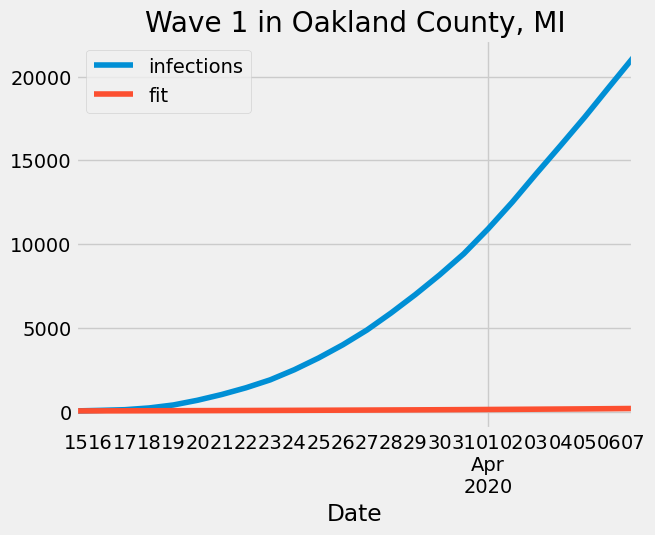

In [43]:
wave1[["infections", "fit"]].plot(title="Wave 1 in Oakland County, MI")

<AxesSubplot:title={'center':'Wave 2 in Oakland County, MI'}, xlabel='Date'>

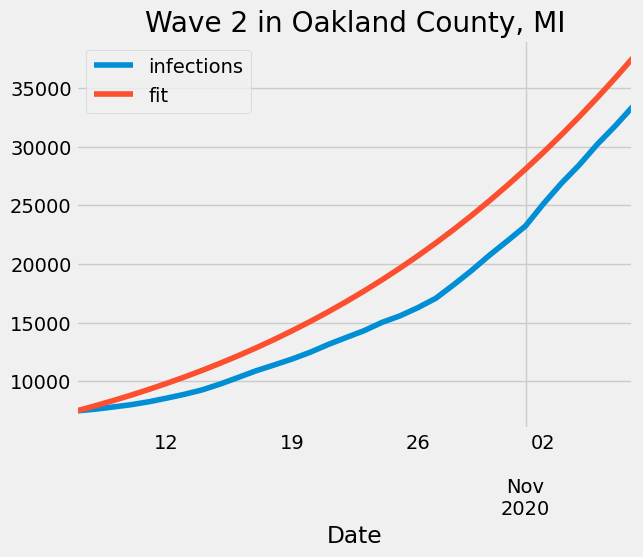

In [44]:
wave2[["infections", "fit"]].plot(title="Wave 2 in Oakland County, MI")

<AxesSubplot:title={'center':'Wave 3 in Oakland County, MI'}, xlabel='Date'>

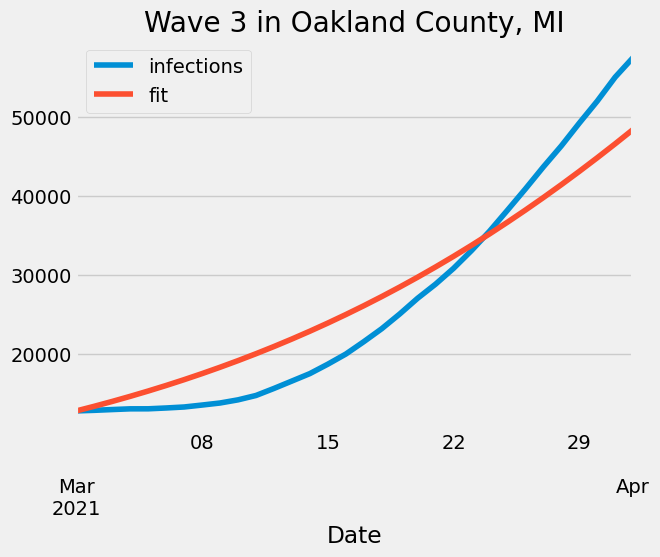

In [45]:
wave3[["infections", "fit"]].plot(title="Wave 3 in Oakland County, MI")

<AxesSubplot:title={'center':'Wave 4 in Oakland County, MI'}, xlabel='Date'>

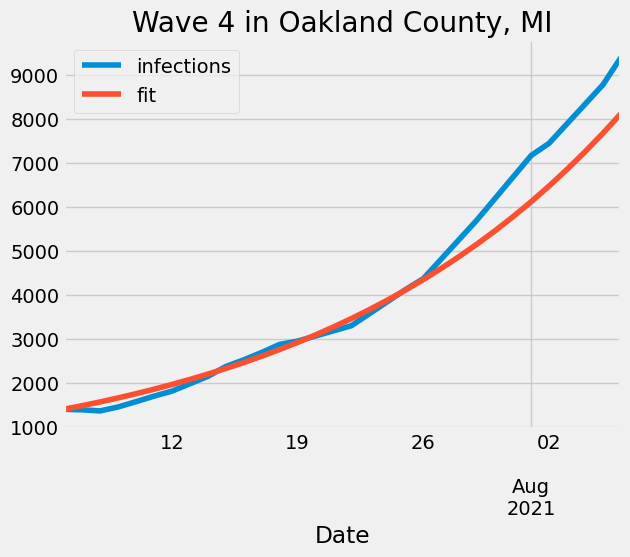

In [46]:
wave4[["infections", "fit"]].plot(title="Wave 4 in Oakland County, MI")

Except the first wave, our model fits reasonably well the other waves.  
Comparing `beta_mask` and `beta_wo_mask` we see the two have very similar values, so we don't find any evidence that the beta values of the parameter were lower during the masking mandates.

In [37]:
best

{'beta_mask': 0.1623748633423853, 'beta_wo_mask': 0.1625971183690065}

However, this is a very simplistic analysis and doesn't take into account factors like human networks, population characteristics, immunity due to vaccination, previous infections. Also we have only looked at a single county.  
We need to be careful about drawing conclusions from this as this model doesn't fully capture the intricate details necessary to determine the impact of masking. Further, we are only looking at the cases that tested positive and we don't have sufficient data to determine what the actual infection progression looked like. Thus, we need to take into account the limitations of both the data and the model while drawing insights from any data science project.